In [ ]:
<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 2 - Collaborative Filtering</center></h3>


In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection as cv
from sklearn.metrics import mean_squared_error
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
import jax
import jax.numpy as jnp
import numpy as onp

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.seterr(divide='ignore', invalid='ignore')

/Users/cainanguan/miniforge3/envs/jax_env/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 1. Load Data

In [3]:
# Read Data
data_path="./ml-1m"
header = ["UserID","Gender","Age","Occupation","Zipcode"]
users = pd.read_csv(data_path + "/users.dat", sep = "::", header=None, names=header, engine='python')

header = ["MovieID","Title","Genres"]
movies = pd.read_csv(data_path + "/movies.dat", sep = "::", header=None, names=header, engine='python')
header = ["UserID","MovieID","Rating","Timestamp"]
ratings = pd.read_csv(data_path + "/ratings.dat", sep = "::", header=None, names=header, engine='python')

# n_users = len(df_users)
# n_items = len(df_movies)
n_users = max(ratings.UserID)
n_items = max(ratings.MovieID)
print('User #: ', n_users)
print('Movie #: ', n_items)

User #:  6040
Movie #:  3952


## 2. Data Visualization

### Users Data

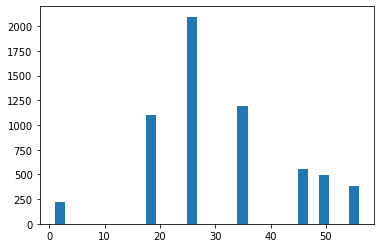

In [7]:
# age distribution
plt.hist(x=users.Age, bins=30)
plt.savefig("./user_age.jpg",dpi=200, bbox_inches='tight')
plt.show()

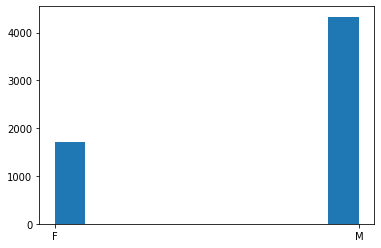

In [9]:
# gender distribution
plt.hist(x=users.Gender, bins=10)
# plt.savefig("./user_gender.jpg",dpi=200, bbox_inches='tight')
plt.show()

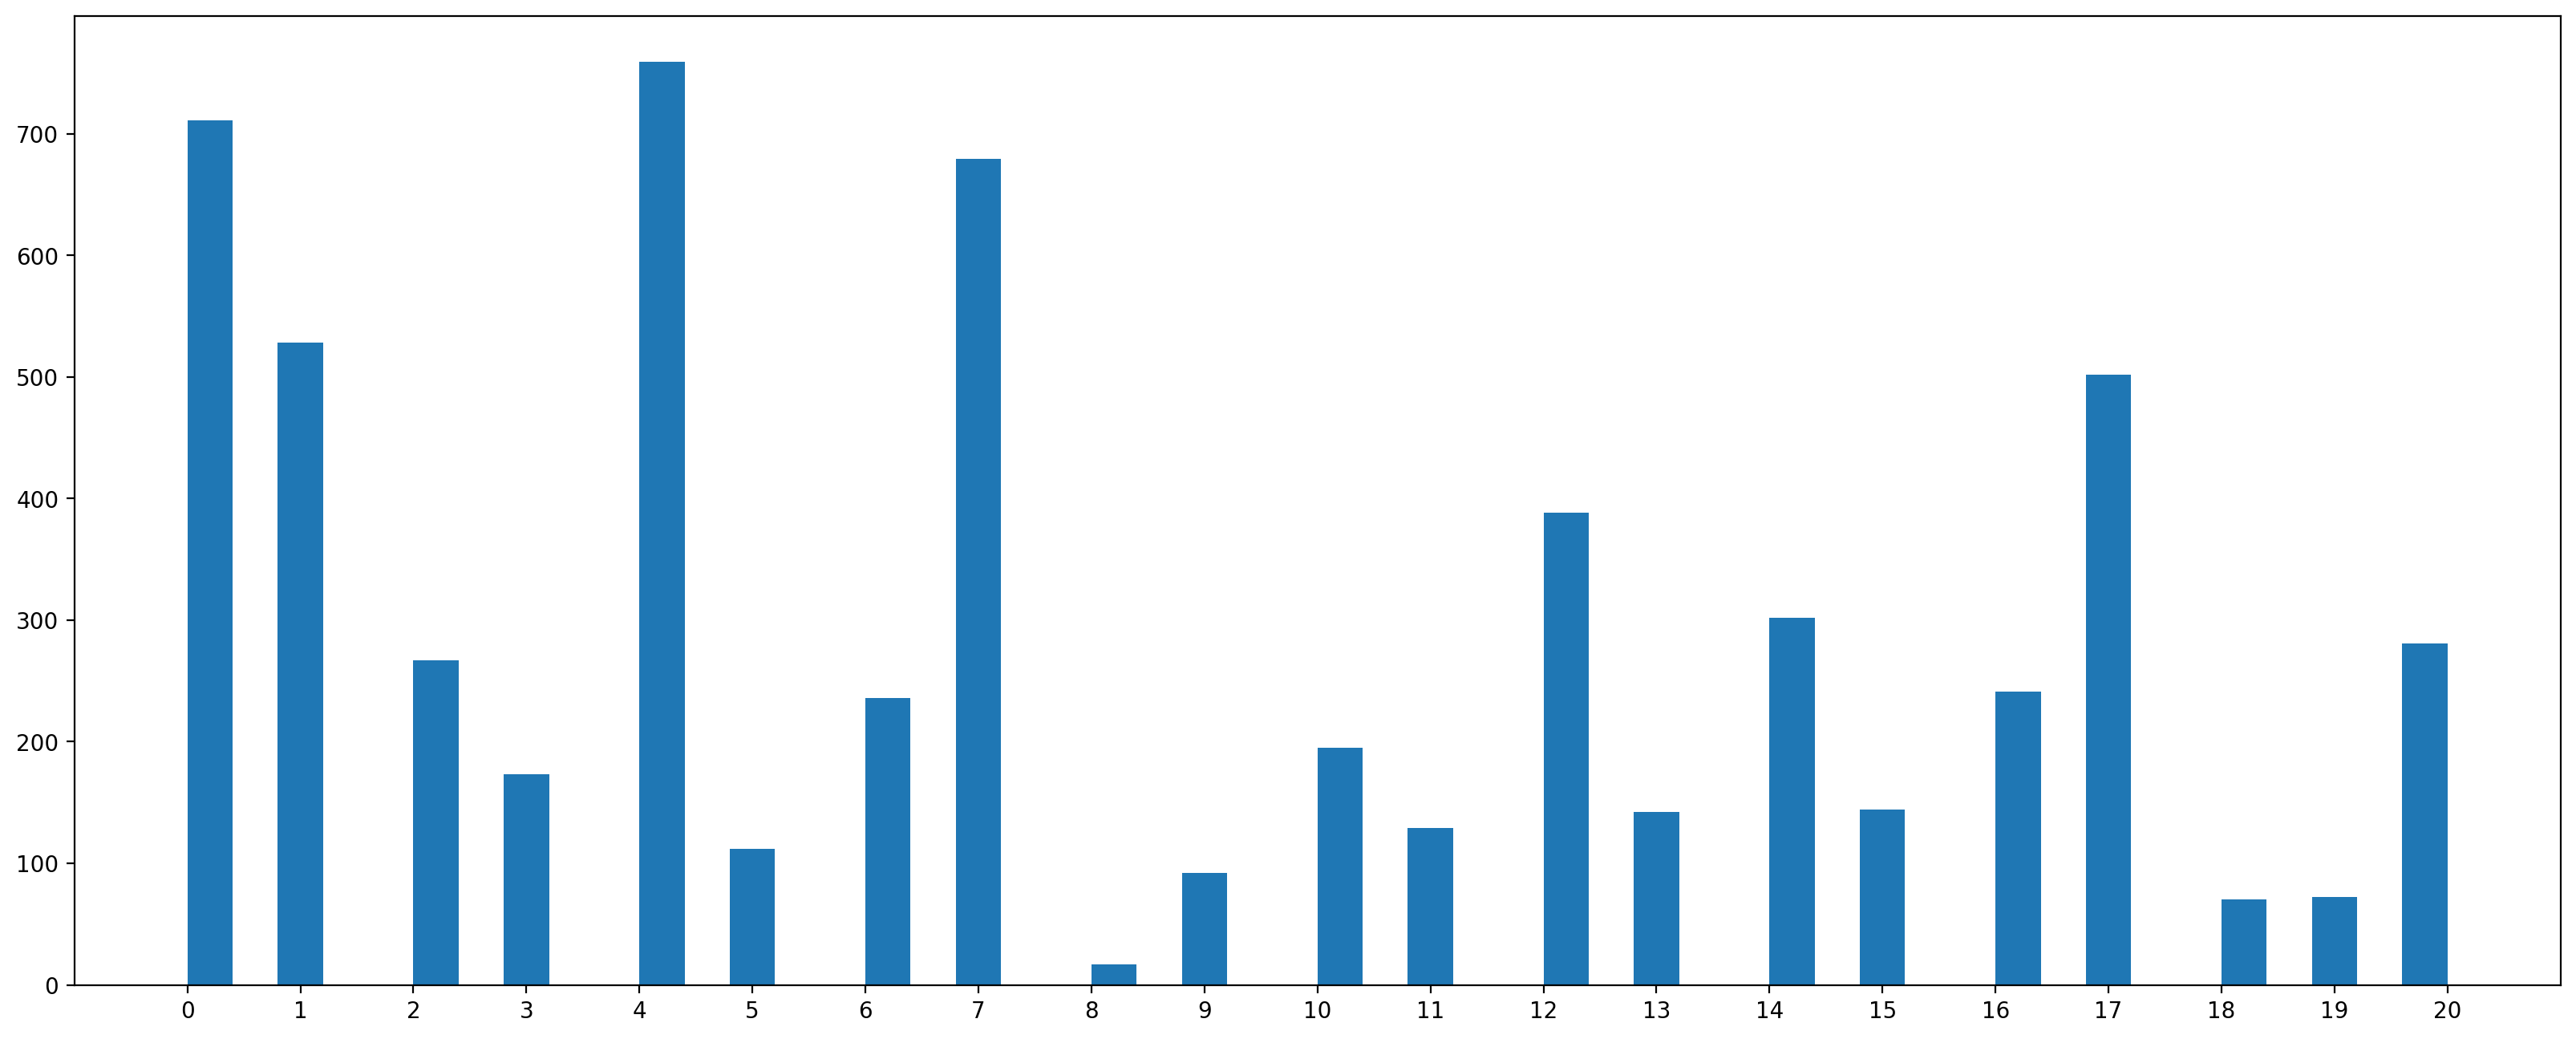

In [10]:
# occupation distribution
fig = plt.figure(figsize=(20, 8), dpi=200)
plt.xticks(range(0,21))
plt.hist(x=users.Occupation, bins=50)
# plt.savefig("/content/gdrive/MyDrive/4212/hw2/image/user_occupation.jpg",dpi=200, bbox_inches='tight')
plt.show()

### Ratings Data

In [18]:
# convert "Timestamp" to timestamp type and extract year and month and sort the records by timestamp.

ratings['Timestamp'] = ratings['Timestamp'].apply(datetime.fromtimestamp)
ratings['year'] = ratings['Timestamp'].dt.year
ratings['month'] = ratings['Timestamp'].dt.month
ratings['date'] = ratings['Timestamp'].dt.date
ratings = ratings.sort_values('Timestamp').reset_index(drop=True)

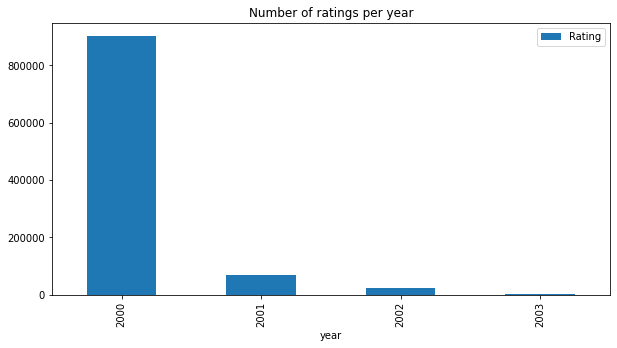

In [19]:
# Inspect rating years
ratings[['year', 'Rating']].groupby(['year']).count().reset_index().plot.bar(x='year', y='Rating', title='Number of ratings per year', figsize=(10, 5));

* We can see that most number of ratings are available for the year **2000** (approximately 900k, which is equivalent to around 90% of the data points).

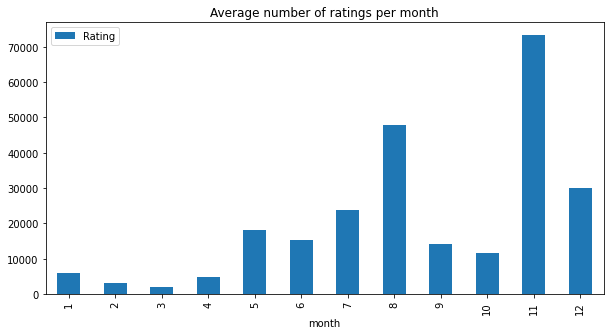

In [20]:
# Rating Month
df_temp = ratings[['month', 'Rating']].groupby(['month']).count().reset_index()
df_temp['Rating'] = df_temp['Rating'] / 4
df_temp.plot.bar(x='month', y='Rating', title='Average number of ratings per month', figsize=(10, 5));

* It is observed that November has the highest average number of the ratings(approximately 70k) followed by August(approximately 50k) and December(30k).

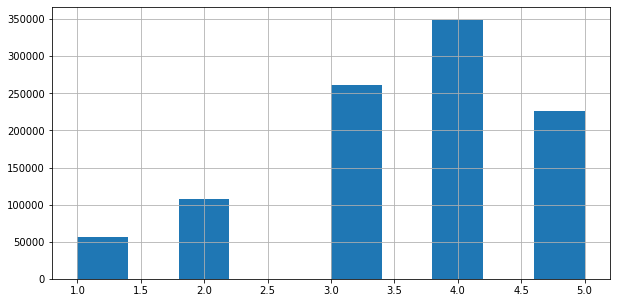

In [21]:
# distribution of different rating values. 
ratings['Rating'].hist(figsize=(10, 5));

* We can see that most common rating value is 4 with an approximate count of 350k. As we have 1M ratings we can say that around 35% of ratings are of value 4 followed by approximately 26% and 21% respectively for 3 and 5.

### Movie Data

In [22]:
# split release year in "Title" and create a new column called release_year.
movies['release_year'] = movies.Title.str.extract("\((\d{4})\)", expand=True).astype(str)

In [23]:
movies['release_year'] = pd.to_datetime(movies.release_year, format='%Y')
movies['release_year'] = movies.release_year.dt.year
movies['Title'] = movies.Title.str[:-7]
movies.head(5)

,MovieID,Title,Genres,release_year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


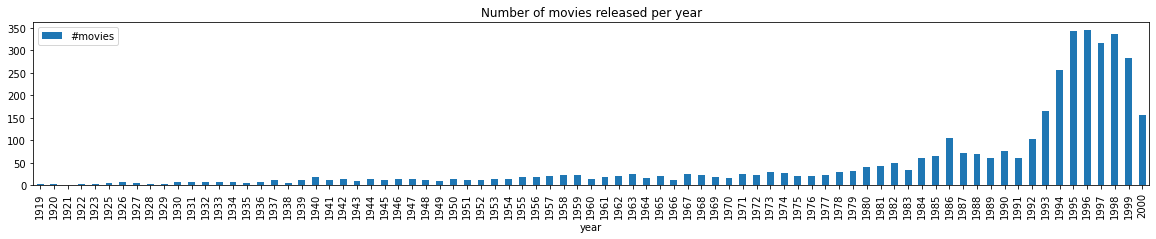

In [24]:
# Movie release year
df_temp = movies[['release_year', 'MovieID']].groupby(['release_year']).count().reset_index().rename(columns={'release_year':'year', 'MovieID':'#movies'})
df_temp.plot.bar('year', '#movies', title='Number of movies released per year', figsize=(20, 3));

In [25]:
# Printing unique genres. 
genres_unique = pd.DataFrame(movies.Genres.str.split('|').tolist()).stack().unique()
print('Unique genres', genres_unique)
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])

Unique genres ['Animation' "Children's" 'Comedy' 'Adventure' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Sci-Fi' 'Documentary' 'War'
 'Musical' 'Mystery' 'Film-Noir' 'Western']


In [26]:
# change to character matrix
df_movie = movies.join(movies.Genres.str.get_dummies().astype(bool))
df_movie.drop('Genres', inplace=True, axis=1)

In [27]:
df_movie.head()

,MovieID,Title,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,False,False,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995,False,True,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,Father of the Bride Part II,1995,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


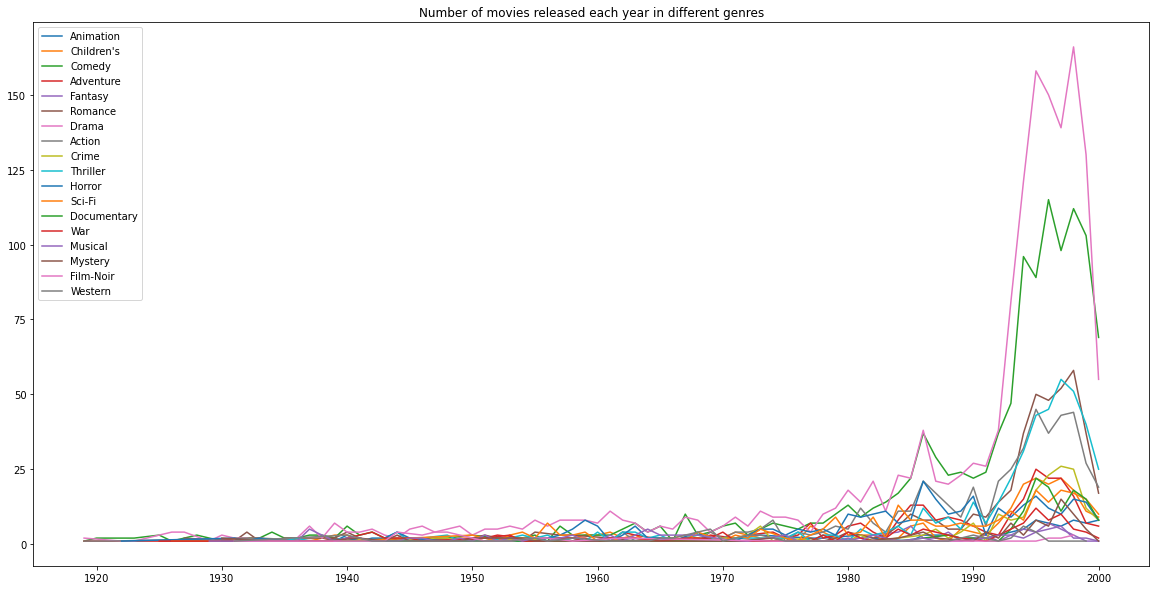

In [29]:
plt.figure(figsize=(20,10)) 
for genre in genres_unique.genre:
    df_temp = df_movie[df_movie[genre]==True][['release_year', 'MovieID']]
    df_temp = df_temp.groupby(['release_year']).count().reset_index().rename(columns={'release_year':'year', 'MovieID':'#movies'})
    plt.plot(df_temp['year'], df_temp['#movies'], label=genre)
plt.title('Number of movies released each year in different genres')
plt.legend()
# plt.savefig("/content/gdrive/MyDrive/4212/hw2/image/number of movie.jpg",dpi=200, bbox_inches='tight')
plt.show()

* There was huge hype for Film-Noir and comdy genre type in late 90s.

### Multiple Datasets

In [30]:
# Adding movies and user data to rating data
df_temp = ratings.merge(df_movie, left_on='MovieID', right_on='MovieID', how='left')
df_final = df_temp.merge(users, left_on='UserID', right_on='UserID', how='left')
df_final.head()

,UserID,MovieID,Rating,Timestamp,year,month,date,Title,release_year,Action,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,Gender,Age,Occupation,Zipcode
0,6040,858,4,2000-04-26 07:05:32,2000,4,2000-04-26,"Godfather, The",1972,True,...,False,False,False,False,False,False,M,25,6,11106
1,6040,2384,4,2000-04-26 07:05:54,2000,4,2000-04-26,Babe: Pig in the City,1998,False,...,False,False,False,False,False,False,M,25,6,11106
2,6040,593,5,2000-04-26 07:05:54,2000,4,2000-04-26,"Silence of the Lambs, The",1991,False,...,False,False,False,True,False,False,M,25,6,11106
3,6040,1961,4,2000-04-26 07:06:17,2000,4,2000-04-26,Rain Man,1988,False,...,False,False,False,False,False,False,M,25,6,11106
4,6040,2019,5,2000-04-26 07:06:17,2000,4,2000-04-26,Seven Samurai (The Magnificent Seven) (Shichin...,1954,True,...,False,False,False,False,False,False,M,25,6,11106


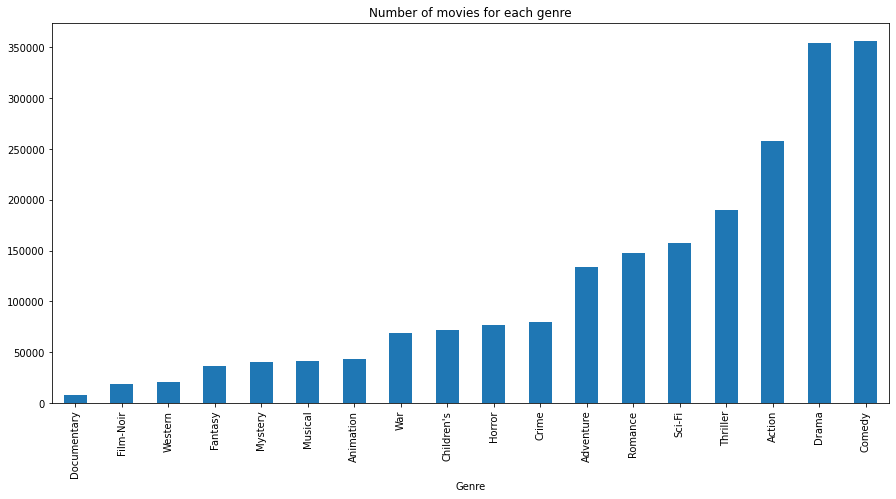

In [31]:
df_temp = pd.DataFrame(columns=['genre', 'num_movies'])
for genre in genres_unique.genre:
    row = [genre, df_final[df_final[genre]==True][['MovieID']].count()]
    df_temp.loc[len(df_temp)] = row
df_temp['num_movies'] = df_temp['num_movies'].astype(np.int32)
df_temp = df_temp.sort_values('num_movies', ascending=True).set_index('genre')
plot_fig = df_temp['num_movies'].plot(kind='bar', figsize=(15,7))
plot_fig.set_title('Number of movies for each genre')
plot_fig.set_xlabel('Genre');

* The comedy drama are having very high number of movies followed by Action and Thriller.

Text(0.5, 0, 'Average Rating')

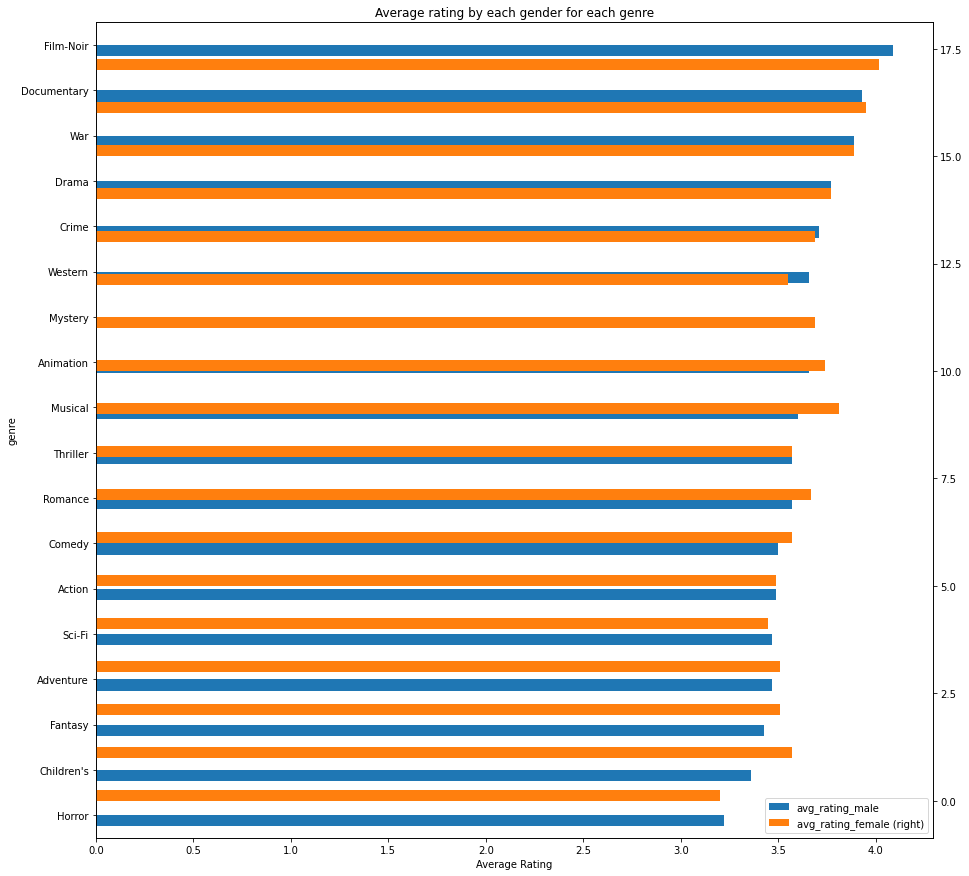

In [35]:
df_temp = pd.DataFrame(columns=['genre', 'avg_rating_male', 'avg_rating_female'])
for genre in genres_unique.genre:
    rating_m = round(df_final[(df_final[genre]==True) & (df_final['Gender']=='M')][['Rating']].mean(), 2).to_string()[6:]
    rating_f = round(df_final[(df_final[genre]==True) & (df_final['Gender']=='F')][['Rating']].mean(), 2).to_string()[6:]
    row = [genre, rating_m, rating_f]
    df_temp.loc[len(df_temp)] = row
    
cols = ['avg_rating_male', 'avg_rating_female']
df_temp[cols] = df_temp[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_temp = df_temp.sort_values('avg_rating_male', ascending=True).set_index('genre')
plot_fig = df_temp.plot( kind= 'barh' , secondary_y= 'avg_rating_female', figsize=(15,15))
plot_fig.set_title('Average rating by each gender for each genre')
plot_fig.set_xlabel('Average Rating')
# plt.savefig("/content/gdrive/MyDrive/4212/hw2/image/average rating by each gender for each genre.jpg",dpi=200, bbox_inches='tight')

* We can see that there is no much difference in the average rating of men and women for different genres.

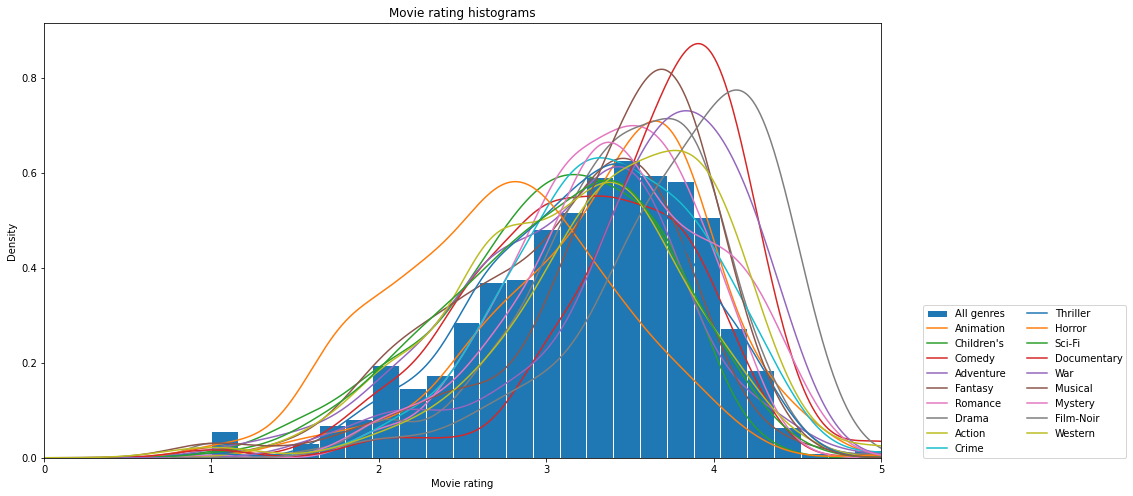

In [36]:
df0 = df_final[['MovieID','Rating']].groupby('MovieID').mean()
df0.hist(bins=25, grid=False, edgecolor='w', density=True, label ='All genres', figsize=(15,8), stacked=True)

for genre in genres_unique.genre:
    df0 = df_final[df_final[genre]==1]
    df0 = ratings[ratings.set_index('MovieID').index.isin(df0.set_index('MovieID').index)]
    df0 = df0[['MovieID','Rating']].groupby('MovieID').mean()
    df0.Rating.plot(grid=False,  kind='kde', label=genre)
    
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

#### Insight From Visualization Part:


1.   On the whole, for all film genres, most people chooce 3 or 4 as 'Rating', very few people choose 1 or 5.
2.   The genre with the lowest average score is animation, at about 2.8, while film-noir has the highest average score which is around 4.2.
3.   The genre with the most concentrated data is comedy, most people choose a score of 4, while rating data of animation is the most loose， people choose score from 2 to 4.





## 3. Collaborative Filtering (Movie recommendation for our users)

### Train / Test Data Split

In [5]:
train_data, test_data = cv.train_test_split(ratings, test_size=0.1)

#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]
print(train_data_matrix.shape)
print(train_data_matrix)

(6040, 3952)
[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
# see people ratings # to movie
np.nonzero(train_data_matrix[0])

(array([   0,   47,  149,  259,  530,  587,  593,  594,  607,  660,  719,
         744,  782,  913,  918,  937, 1027, 1028, 1034, 1192, 1206, 1245,
        1269, 1286, 1544, 1565, 1720, 1835, 1906, 1960, 1961, 2017, 2027,
        2293, 2339, 2354, 2397, 2686, 2761, 2790, 2796, 2803, 2917, 3104,
        3113, 3185, 3407]),)

#### Insights From The Data

1. The rating matrix is a **sparse matrix**, which means the majority of the matrix value will be 0.
2. While 0 is lower than [1-5], in the computation of cosine similarity, the 0 will be seen as a sign of **'hate'** to the certain movie, which is not fair.
3. To solve the problem beforementioned, we need to change 0 to 'Neutal'. Thus, we need to **standardize** the ratings to mean 0 (In this way, **0 becomes 'Neutral'**)

### Standardize Ratings

In [7]:
def nonzero_mean(np_arr):
    """
    Calculate the mean / std of the elements in each row that are not 0 in a matrix
    """
    exist = (np_arr != 0)
    arr_sum = np_arr.sum(axis=1)
    arr_num = exist.sum(axis=1)
    avg_n = arr_sum / arr_num
    
    # Cal Std
    all_sum = list(map(lambda x, y: (x - avg_n[y]) ** 2, np_arr, range(len(np_arr))))
    std_n = np.sqrt(np.sum(all_sum, axis=1))/ arr_num
    return avg_n, std_n



def standard_data(np_arr):
    standardized_df = np_arr.copy()
    nonzero_rows = np.nonzero(np_arr)[0]
    nonzero_columns = np.nonzero(np_arr)[1]
    nonzero_rows_mean, nonzero_rows_std = nonzero_mean(np_arr)
    
    for ind in range(len(nonzero_rows)):
        i = nonzero_rows[ind]
        j = nonzero_columns[ind]
        standardized_df[i, j] = round(np_arr[i, j] - nonzero_rows_mean[i], 2) / nonzero_rows_std[i]
    return standardized_df

train_data_matrix = standard_data(train_data_matrix)
test_data_matrix = standard_data(test_data_matrix)

In [8]:
idx = 0
train_data_matrix[idx][train_data_matrix[idx].nonzero()]

array([ 0.14102134,  0.14102134,  0.14102134, -0.03748669, -0.03748669,
       -0.03748669, -0.03748669,  0.14102134, -0.03748669, -0.21599471,
       -0.21599471, -0.21599471, -0.03748669, -0.21599471, -0.03748669,
       -0.03748669,  0.14102134,  0.14102134,  0.14102134,  0.14102134,
       -0.03748669, -0.03748669,  0.14102134,  0.14102134, -0.03748669,
       -0.03748669, -0.03748669,  0.14102134, -0.03748669,  0.14102134,
       -0.03748669, -0.03748669,  0.14102134, -0.03748669, -0.21599471,
        0.14102134, -0.03748669, -0.21599471, -0.03748669, -0.03748669,
       -0.03748669,  0.14102134, -0.03748669,  0.14102134, -0.03748669,
       -0.03748669, -0.03748669])

## 3.1 User-based CF

#### We compute cosine distance in the follwing block, with formula:  $Cosine Dist = \frac{\overrightarrow{A} \cdot \overrightarrow{B}}{\mid A \mid \mid B \mid}$

#### Steps:
* Calculate matrix $ A_{i,j} \in R^{m x n}$, which saves $\overrightarrow{A} \cdot \overrightarrow{B}$ for each i, j;
* Calculate a symmetric matrix $B_{i,j} \in R^{m x n}$, which saves |A| * |B| for each rows in train_data_matrix.
* A / B get the cosine distance.

In [9]:
## Compute user similarity 
def distCosine(x, y):
    A = np.dot(x, y.T) 
    B = np.sqrt(A.diagonal().reshape(-1, 1) @ A.diagonal().reshape(1, -1))
    return A / B

user_similarity = distCosine(train_data_matrix, train_data_matrix)
user_similarity = np.nan_to_num(user_similarity) # some users may mot have ratings (divide by 0)
print(user_similarity)

[[ 1.          0.01962171 -0.03039199 ...  0.          0.00139483
  -0.01069631]
 [ 0.01962171  1.          0.         ... -0.01073942  0.02999495
  -0.00455232]
 [-0.03039199  0.          1.         ...  0.05597968  0.02014269
  -0.03907416]
 ...
 [ 0.         -0.01073942  0.05597968 ...  1.          0.04878273
  -0.05024902]
 [ 0.00139483  0.02999495  0.02014269 ...  0.04878273  1.
   0.06359567]
 [-0.01069631 -0.00455232 -0.03907416 ... -0.05024902  0.06359567
   1.        ]]


In [10]:
'''
Define functions
'''
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

def predict_user_user(train_matrix, user_similarity):
    preds = np.dot(user_similarity, train_matrix) / np.array([np.abs(user_similarity).sum(axis=1)]).reshape(-1, 1)
    return preds

In [11]:
predictions = predict_user_user(train_data_matrix, user_similarity)
predictions = np.nan_to_num(predictions)
print('predictions shape ',predictions.shape)
predictions

predictions shape  (6040, 3952)


array([[ 2.72897446e-01, -3.49557915e-02, -2.84973712e-02, ...,
         3.72070897e-03,  2.86325670e-03,  1.76604809e-02],
       [ 2.98417558e-01, -7.61496324e-02, -5.17633106e-02, ...,
         7.03334893e-03, -1.29948622e-03,  3.51858886e-02],
       [ 1.25248459e-01, -5.92365434e-02, -2.63105591e-02, ...,
        -7.87529742e-04, -6.67425723e-04,  1.09342044e-02],
       ...,
       [-3.87602146e-02,  2.85397593e-02, -6.84281097e-03, ...,
         1.31850908e-03, -1.59278210e-03,  3.99310314e-03],
       [ 2.06394336e-01, -7.98057513e-02, -4.46552801e-02, ...,
         4.37160925e-03, -2.03203817e-03,  2.87736946e-02],
       [ 3.61869389e-01, -1.40793989e-01, -1.16676802e-01, ...,
         9.31880548e-05, -3.13512218e-03,  5.38736857e-02]])

In [12]:
predicted_ratings = predictions[test_data_matrix.nonzero()]
test_truth = test_data_matrix[test_data_matrix.nonzero()]
print ('User-based CF RMSE: ' + str(rmse(predicted_ratings, test_truth)))

User-based CF RMSE: 0.2688687551545188


In [13]:
predicted_ratings

array([ 0.25938231,  0.04504195,  0.16495691, ...,  0.05194209,
        0.04801513, -0.010606  ])

In [14]:
test_truth

array([ 0.02387806,  0.02387806, -0.02387806, ..., -0.07794804,
        0.22185212, -0.37774821])

## 3.2 Item-based CF

In [15]:
## Computr item similarity
item_similarity = distCosine(train_data_matrix.T, train_data_matrix.T)
item_similarity.shape

(3952, 3952)

In [16]:
item_similarity = np.nan_to_num(item_similarity)
item_similarity

array([[ 1.00000000e+00, -8.11005626e-02, -1.47788843e-01, ...,
         4.03864464e-02, -8.97358911e-02,  6.64333871e-02],
       [-8.11005626e-02,  1.00000000e+00,  1.69761132e-01, ...,
         1.19906050e-01, -6.43456419e-05, -1.35067804e-01],
       [-1.47788843e-01,  1.69761132e-01,  1.00000000e+00, ...,
         1.48279378e-01,  9.42315959e-02, -7.25072315e-02],
       ...,
       [ 4.03864464e-02,  1.19906050e-01,  1.48279378e-01, ...,
         1.00000000e+00, -2.85020918e-02, -9.97377435e-03],
       [-8.97358911e-02, -6.43456419e-05,  9.42315959e-02, ...,
        -2.85020918e-02,  1.00000000e+00,  1.79973714e-01],
       [ 6.64333871e-02, -1.35067804e-01, -7.25072315e-02, ...,
        -9.97377435e-03,  1.79973714e-01,  1.00000000e+00]])

In [17]:
def predict_item_item(train_matrix, item_similarity):
    preds = np.dot(train_matrix, item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])
    return preds

In [18]:
predictions = predict_item_item(train_data_matrix, item_similarity)
print('predictions shape ',predictions.shape)
predictions = np.nan_to_num(predictions)
predictions

predictions shape  (6040, 3952)


array([[ 6.96604742e-04, -2.20170501e-04, -3.23981687e-04, ...,
        -1.44148724e-04,  3.75527117e-05,  3.31069458e-04],
       [ 1.10087075e-02, -5.11387805e-03, -2.72463377e-03, ...,
         9.93409695e-04, -2.69868449e-03,  5.53374786e-03],
       [ 6.80651838e-04, -7.53734161e-04, -2.65041863e-04, ...,
        -4.65022038e-04, -3.97080245e-04,  4.11947484e-04],
       ...,
       [-9.42560854e-05,  6.45886993e-05, -3.13898017e-05, ...,
         2.62172216e-05, -1.87970808e-05,  3.30426930e-05],
       [ 3.32425647e-03, -3.76367172e-03, -2.26608204e-03, ...,
        -1.95849218e-04, -1.09990997e-03,  2.44551453e-03],
       [ 9.81850376e-02, -9.57403911e-02, -8.39161677e-02, ...,
        -2.91469786e-02, -4.00416543e-02,  7.92858348e-02]])

In [19]:
predicted_ratings = predictions[test_data_matrix.nonzero()]
test_truth = test_data_matrix[test_data_matrix.nonzero()]
print ('Item-based CF RMSE: ' + str(rmse(predicted_ratings, test_truth)))

Item-based CF RMSE: 0.35164418904087713


In [20]:
predicted_ratings

array([0.00064727, 0.00055372, 0.00033223, ..., 0.0648905 , 0.0508121 ,
       0.01506607])

In [21]:
test_truth

array([ 0.02387806,  0.02387806, -0.02387806, ..., -0.07794804,
        0.22185212, -0.37774821])

### Try to Recommendation for users

In [22]:
user_id = 77
user_ratings = predictions[user_id-1,:]

In [23]:
train_unkown_indices = np.where(train_data_matrix[user_id-1,:] == 0)[0]
train_unkown_indices

array([   0,    1,    2, ..., 3949, 3950, 3951])

In [24]:
user_recommendations = user_ratings[train_unkown_indices]
user_recommendations.shape

(3914,)

In [25]:
print('\nRecommendations for user {} are the movies:'.format(user_id))

for movie_id in user_recommendations.argsort()[-5:][: : -1]:
    print(movie_id +1, end=' ')


Recommendations for user 77 are the movies:
2883 192 705 2195 786 

## 3.3 SVD for CF

In [31]:
# Define Loss Function
lamb = 0.1 # reg params
r = 20 # suppose there are 20 types of movies
A = train_data_matrix
reg = True

@jax.jit
def MSE(U,V,A):
    # Regularization
    if reg:
        error = (A - U @ V) ** 2 + lamb * (U @ U.T).diagonal().reshape(-1, 1) @ (V.T @ V).diagonal().reshape(1, -1)
    # No Reg
    else: 
        error = (A - U @ V) ** 2
    return jnp.mean(error)

MSE_grad_u = jax.jit(jax.grad(MSE, argnums=0))
MSE_grad_v = jax.jit(jax.grad(MSE, argnums=1))

In [32]:
# initiate U & V
U_init = onp.random.normal(0,1,size=(n_users, r))
V_init = onp.random.normal(0,1,size=(r, n_items))

In [33]:
grad_u = MSE_grad_u(U_init, V_init, A)
grad_u.shape

(6040, 20)

In [34]:
'''
Train Model
'''
U, V = onp.copy(U_init), onp.copy(V_init)
# parallel update of parameters
niter = 50
learning_rate = 100.
loss_history = []

for _ in range(niter):
    # compute the gradients
    grad_u = MSE_grad_u(U,V,A)
    grad_v = MSE_grad_v(U,V,A)
    
    # do the gradient updates
    U = U - learning_rate * grad_u
    V = V - learning_rate * grad_v
    
    # check the loss for monitoring purposes
    current_loss = MSE(U,V,A)
    loss_history.append(current_loss)

In [30]:
loss_history_non_reg = loss_history

In [35]:
loss_history_reg = loss_history

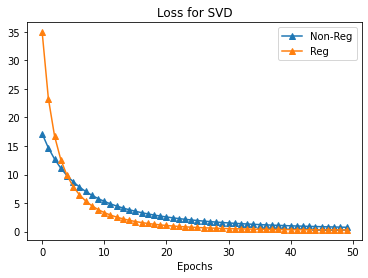

In [44]:
plt.plot(loss_history_non_reg, "-^", label='Non-Reg')
plt.plot(loss_history_reg, "-^", label='Reg')
plt.title('Loss for SVD')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [159]:
# get predictions
predictions = U @ V
predicted_ratings = predictions[test_data_matrix.nonzero()]
test_truth = test_data_matrix[test_data_matrix.nonzero()]
print ('SVD RMSE: ' + str(rmse(predicted_ratings, test_truth)))

SVD RMSE: 0.2927068373614062


## 3. 4 Biased SVD for CF

#### Biased SVD Model:

$R_{u,i} = \mu + b_i + b_u + Q_i^{T}P_u$

$\mu: $ **The global average of ratings across all records in the training set**. In different movie websites, the overall score distribution of the website will also show some differences because the website positioning and the items sold are different. For example, users of some websites like to give high scores, while users of other websites just like to give low scores. The global average can represent the impact of the website itself on user ratings. **But since we standardize the dataset in the very begining, we can drop this const value.**

$b_u: $ **User bias term.** This item represents the kinds of factors in the user's rating habits that are not related to the item. For example, some users are more demanding and have high requirements for everything, so their ratings will be low, while some users are more tolerant and feel good about everything, then their ratings will be high.

$b_i: $ **item bias term.** This item represents factors in the item's acceptance rating that have little to do with the user. For example, some items are of high quality, so they get relatively high ratings, while some items are of poor quality, so they get relatively low ratings.


In [49]:
# Define Loss Function
lamb = 0.1 # reg params
r = 20 # suppose there are 20 types of movies
A = train_data_matrix
reg = True
# u = np.mean(train_data_matrix[train_data_matrix.nonzero()])

@jax.jit
def MSE(U, V, b_i, b_u, A):
    # Regularization
    if reg:
        error = (A - U @ V + b_i @ b_u) ** 2 + lamb * ((U @ U.T).diagonal().reshape(-1, 1) @ (V.T @ V).diagonal().reshape(1, -1) + jnp.linalg.norm(b_i.flatten()) + jnp.linalg.norm(b_u.flatten()))
        
    else:
        error = (A - U @ V + b_i @ b_u) ** 2
        
    return jnp.mean(error)

MSE_grad_u = jax.jit(jax.grad(MSE, argnums=0))
MSE_grad_v = jax.jit(jax.grad(MSE, argnums=1))
MSE_grad_b_i = jax.jit(jax.grad(MSE, argnums=2))
MSE_grad_b_u = jax.jit(jax.grad(MSE, argnums=3))

In [50]:
# Init params
U_init = onp.random.normal(0,1,size=(n_users, r))
V_init = onp.random.normal(0,1,size=(r, n_items))
b_i_init = onp.random.normal(0,1,size=(n_users, 1))
b_u_init = onp.random.normal(0,1,size=(1, n_items))

In [51]:
'''
Train Model
'''
U, V = onp.copy(U_init), onp.copy(V_init)
b_i, b_u = b_i_init, b_u_init
# parallel update of parameters
niter = 50
learning_rate = 100.
loss_history = []

for _ in range(niter):
    # compute the gradients
    grad_u = MSE_grad_u(U, V, b_i, b_u, A)
    grad_v = MSE_grad_v(U, V, b_i, b_u, A)
    grad_b_i = MSE_grad_b_i(U, V, b_i, b_u, A)
    grad_b_u = MSE_grad_b_u(U, V, b_i, b_u, A)
    
    # do the gradient updates
    U = U - learning_rate * grad_u
    V = V - learning_rate * grad_v
    b_i = b_i - learning_rate * grad_b_i
    b_u = b_u - learning_rate * grad_b_u
    
    # check the loss for monitoring purposes
    current_loss = MSE(U, V, b_i, b_u, A)
    loss_history.append(current_loss)

In [48]:
loss_history_non_reg = loss_history

In [52]:
loss_history_reg = loss_history

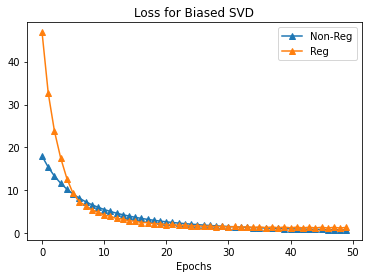

In [53]:
plt.plot(loss_history_non_reg, "-^", label='Non-Reg')
plt.plot(loss_history_reg, "-^", label='Reg')
plt.title('Loss for Biased SVD')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [180]:
# get predictions
predictions = U @ V + b_i @ b_u
predicted_ratings = predictions[test_data_matrix.nonzero()]
test_truth = test_data_matrix[test_data_matrix.nonzero()]
print ('SVD RMSE: ' + str(rmse(predicted_ratings, test_truth)))

SVD RMSE: 0.29335976549744547


In [185]:
'''
Try to recommendate movies
'''
user_id = 3
user_ratings = predictions[user_id-1,:]

train_unkown_indices = np.where(train_data_matrix[user_id-1,:] == 0)[0]
user_recommendations = user_ratings[train_unkown_indices]
print(user_recommendations.shape)

print('\nTop 5 Movie Recommendations for user {} are the movies:'.format(user_id))

for movie_id in user_recommendations.argsort()[-5:][: : -1]:
    print(movie_id +1, end=' ')

(3904,)

Top 5 Movie Recommendations for user 3 are the movies:
1571 3207 1593 1967 2711 

## 3.5 KNN for CF

In [39]:
class KNN_rate:
    def __init__(self):
        self.train_data = None
        self.user_similarity = None
        self.item_similarity = None

    def fit(self, train_data, k=3):  # here the train_data is matrix [user, movie] = rate
        self.train_data = train_data
        self.user_similarity = self.distCosine( train_data, train_data)
        self.item_similarity = self.distCosine( train_data.T, train_data.T)
        # self.user_similarity = pairwise_distances(train_data, metric='cosine')
        # self.item_similarity = pairwise_distances(train_data.T, metric='cosine')
        self.user_similarity = self.user_similarity - np.eye(len(self.user_similarity))
        self.item_similarity = self.item_similarity - np.eye(len(self.item_similarity))
        self.user_similarity = np.nan_to_num(self.user_similarity, nan = 0)
        self.item_similarity = np.nan_to_num(self.item_similarity, nan = 0)
        user_sim = {}
        for i in range(self.user_similarity.shape[0]):
            # if i not in user_sim.keys():
            #     user_sim[i] = []
            inds = np.argsort(self.user_similarity[i])[-k:]
            user_sim[i] = [  {"id": ind, "dist": self.user_similarity[i][ind] }  for ind in inds.tolist()]

        item_sim = {}
        for i in range(self.item_similarity.shape[0]):
            # if i not in item_sim.keys():
            #     item_sim[i] = []
            inds = np.argsort(self.item_similarity[i])[-k:]
            item_sim[i] = [  {"id": ind, "dist": self.item_similarity[i][ind] }  for ind in inds.tolist()]

        return user_sim, item_sim
    
    def distCosine(self, x, y):
        A = np.dot(x, y.T) 
        B = np.sqrt(A.diagonal().reshape(-1, 1) @ A.diagonal().reshape(1, -1))
        return A / B 


    def predict(self, test_data, sim):  # test_data   test_data_matrix/ sim : user_item
        pred = np.zeros(  (test_data.shape[0], test_data.shape[1]) )
        for i in range(test_data.shape[0]):
            if i in sim.keys():
                for j in range(test_data.shape[1]):
                    if test_data[i][j]!= 0:   # predict position 
                        neighbors = [si["id"] for si in sim[i]]
                        pred[i][j] = np.mean([  self.train_data[n][j] for n in neighbors]) # predict the jth movie
        return pred


In [48]:
ks = [5,10,15, 30, 40, 50, 100,200,300,400,500]
knn = KNN_rate()
res_item  = []
res_user = []

for kt in ks:
    user_sim, item_sim = knn.fit(train_data_matrix, k=kt)
    test_res = knn.predict(test_data_matrix, user_sim)
    res_user.append(rmse(test_res, test_data_matrix))

#user_sim = knn.fit(user_dict)

In [49]:
print(rmse(test_res, test_data_matrix))

0.3963432619534762


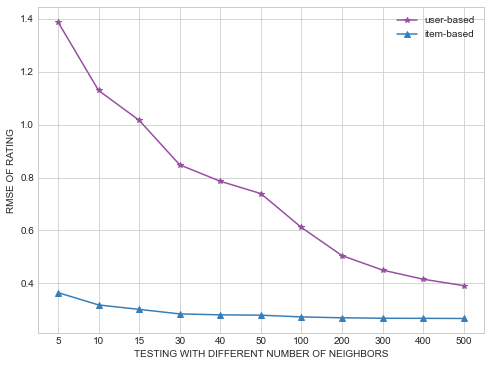

In [50]:
x = ['5', '10', '15', '30', '40','50', '100', '200', '300', '400', '500']
usr = [1.38752,1.1288,1.01623,0.8479, 0.7859, 0.7393, 0.6113, 0.5050, 0.4504,0.4159 ,  0.3917]
itm = [0.3654, 0.3188 ,0.3020,0.2850,0.2814,0.2801,0.2736,0.2703,0.2685,0.2682,0.2677]
plt.figure(figsize=(8, 6))
plt.style.use( 'seaborn-whitegrid') 
palette = plt.get_cmap('Set1')
plt.plot(x, usr, color=palette(3), marker='*', label='user-based')
plt.plot(x, itm, color=palette(1), marker='^', label='item-based')
plt.legend()
plt.xlabel('TESTING WITH DIFFERENT NUMBER OF NEIGHBORS')
plt.ylabel('RMSE OF RATING')
plt.show()


## Comparison

|       |User-Based|Item-based| Reg SVD | Reg Biased SVD | KNN | 
| :----:| :----: | :----: | :----: |:----: |:----: |
| **RMSE** | 0.268 | 0.351 | 0.292 | 0.293 | 0.396 |
| **Training Time**| Fast | Fast | Fast | Medium | Slow |